In [1]:
%matplotlib inline

from IPython.display import clear_output

from NIX_Testing import NIX_Image_List, NIX_Image, doGridAnalysis, ProgressBar
from pylab import *
from astropy.io import fits
from lmfit.models import LinearModel, ConstantModel, StepModel
from lmfit import Model
import pickle
import multiprocessing as mp

data_dir = '/home/ydallilar/Documents/MPE/ERIS/NIX/nixDetBackup'

test_ids = ['PER-124-04-1']
config = {'test_ids' : test_ids, 'data_dir' : data_dir}
NIX_GL = NIX_Image_List(config)

In [2]:
def my_model(x, slope, intercept, satur, switch):
    
    res = slope*x+intercept
    res[where(x > switch)] = satur
    
    return res
    

In [3]:
select = 2*arange(20)+40
dark = 2*arange(20)
exps = 2*arange(20)+2
ims = NIX_GL.getImage(select=select, dark=dark)
ims2 = NIX_GL.getImage(select=select+1, dark=dark)

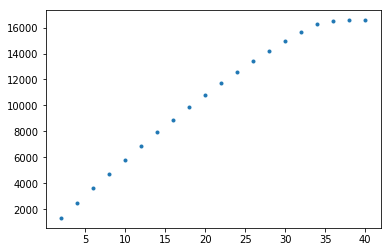

In [4]:
plot(exps, ims[1000, 1200, :], '.')

In [5]:
arr = ims[1000, 1200, :]

step1 = StepModel(prefix='step1_')
step2 = StepModel(prefix='step2_')
lin = LinearModel(prefix='lin_')
const = ConstantModel(prefix='const_')
one = ConstantModel(prefix='one_')

pars = step1.make_params(form='erf')
pars += step2.make_params(form='erf')
pars += lin.guess(arr, x=exps)
pars += const.make_params()
pars += one.make_params(c=1.)

pars['step1_amplitude'].set(value=1., vary=False)
pars['step1_center'].set(value=32.)
pars['step1_sigma'].set(value=0.)
pars['step2_amplitude'].set(expr='step1_amplitude')
pars['step2_center'].set(expr='step1_center')
pars['step2_sigma'].set(expr='step1_sigma')
pars['lin_slope'].set(value=500.)
pars['lin_intercept'].set(value=0)
pars['const_c'].set(value=15000.)
pars['one_c'].set(value=1., vary=False)

print pars.valuesdict()


model = (one-step1)*lin + step2*const

OrderedDict([('step1_amplitude', 1.0), ('step1_sigma', 0.0), ('step1_center', 32.0), ('step2_amplitude', 1.0), ('step2_sigma', 0.0), ('step2_center', 32.0), ('lin_slope', 500.0), ('lin_intercept', 0), ('const_c', 15000.0), ('one_c', 1.0)])


[[Model]]
    Model(my_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 24
    # data points      = 20
    # variables        = 3
    chi-square         = 1551641.55
    reduced chi-square = 91273.0324
    Akaike info crit   = 231.181834
    Bayesian info crit = 234.169031
[[Variables]]
    slope:      479.895498 +/- 8.19222290 (1.71%) (init = 200)
    intercept:  910.284359 +/- 158.430057 (17.40%) (init = 0)
    satur:      16466.7603 +/- 151.057136 (0.92%) == 'slope*switch+intercept'
    switch:     32.4163822 +/- 0.43944250 (1.36%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept)  = -0.879
    C(slope, switch)     = -0.599
    C(intercept, switch) =  0.356
Parameters([('slope', <Parameter 'slope', 200.0, bounds=[-inf:inf]>), ('intercept', <Parameter 'intercept', 0.0, bounds=[-inf:inf]>), ('satur', <Parameter 'satur', 4000.0, bounds=[-inf:inf], expr='slope*switch+intercept'>), ('switch', <Parameter 'switch',

<IPython.core.display.Javascript object>


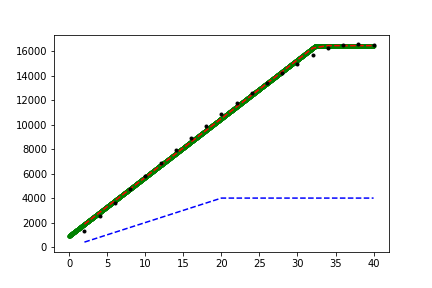

In [8]:
out = model.fit(arr, pars, x=exps)

print out.fit_report()

xx = arange(0,40, 0.01)

print pars
print out.best_values
yy = model.eval(params=out.params, x=xx)

%matplotlib notebook
figure()
plot(xx, yy, 'g.')
plot(exps, out.best_fit, 'r--')
plot(exps, out.init_fit, 'b--')
plot(exps, arr, 'k.')
show()

['slope', 'intercept', 'satur', 'switch']


<IPython.core.display.Javascript object>


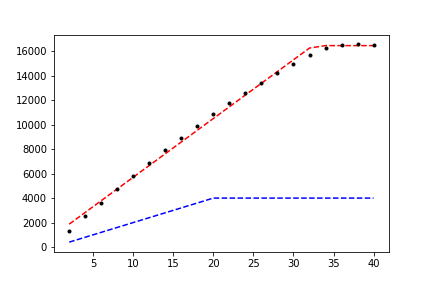

[[Model]]
    Model(my_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 24
    # data points      = 20
    # variables        = 3
    chi-square         = 1551641.55
    reduced chi-square = 91273.0324
    Akaike info crit   = 231.181834
    Bayesian info crit = 234.169031
[[Variables]]
    slope:      479.895498 +/- 8.19222290 (1.71%) (init = 200)
    intercept:  910.284359 +/- 158.430057 (17.40%) (init = 0)
    satur:      16466.7603 +/- 151.057136 (0.92%) == 'slope*switch+intercept'
    switch:     32.4163822 +/- 0.43944250 (1.36%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept)  = -0.879
    C(slope, switch)     = -0.599
    C(intercept, switch) =  0.356


In [9]:
model = Model(my_model)
pars = model.make_params()
print model.param_names
pars['slope'].set(value=200.)
pars['intercept'].set(value=0.)
pars['switch'].set(value=20.)
pars['satur'].set(expr='slope*switch+intercept')
y_eval = model.eval(pars, x=xx)
figure()
#plot(xx, y_eval)
out = model.fit(arr, pars, x=exps)
print out.fit_report()
plot(exps, out.best_fit, 'r--')
plot(exps, out.init_fit, 'b--')
plot(exps, arr, 'k.')
show()
